In [1]:
%run init_notebook.py

In [2]:
import spacy
import regex as re

import time
from itertools import compress
from collections import Counter
from src.utils import vec_similarity, arr_min_max_scale, save_pd_df

from uuid import uuid4
import pickle

In [3]:
from articles import load_pickle, DICT_NARRATIVES, load_pd_df
from src.nlp_utils import get_spacy_NLP, load_raw_data

In [4]:
# load_raw_data('news_data.json')

In [5]:
NLP = get_spacy_NLP('de')

# supervised narrative topics

news data

In [43]:
dict_txts = {}
for file in [i for i in os.listdir(NEWS_TEXT_DIR) if i not in ['orig']]:
    dict_txts[file] = load_pickle(file)

len(dict_txts)

2400

ecb speeches

In [44]:
# dict_txts = {}
# for file in [i for i in os.listdir(TEXT_DIR) if i != 'orig']:
#     dict_txts[file] = load_pickle(file)

## analyse

In [45]:
LST_FREQUENT_NON_MEANING = [
    'prozent',
     'euro',
     'million',
     'milliarde',
     'deutschland',
     'deutsch',
     'land',
     'firma',
     'frage',
    'zahl',
    'woche',
    'monat',
    'stadt',
    'bereich',
    'seite',
    'datum',
    'quartal',
    'tonne',
    'zeit',
    'standort',
]

In [46]:
'Covid' in " ".join([v['text'] for v in dict_txts.values()])

True

In [47]:
Counter([v['is_infl'] for k, v in dict_txts.items()])

Counter({False: 1951, True: 449})

In [48]:
_dict = {}
for idx, text in {k: v for k, v in dict_txts.items() if v['is_infl']}.items():
    counter = text['counter']
    for k, v in counter.items():
        if k not in LST_FREQUENT_NON_MEANING:
            if k not in _dict.keys():
                _dict[k] = v
            elif k in _dict.keys():
                _dict[k] = _dict[k] + v

In [49]:
sorted(_dict.items(), key=lambda x: x[1], reverse=True)[:10]

[('unternehmen', 704),
 ('preis', 461),
 ('dollar', 389),
 ('bank', 287),
 ('kunde', 281),
 ('geld', 266),
 ('aktie', 265),
 ('markt', 261),
 ('usa', 259),
 ('konzern', 256)]

In [14]:
# from scratch

In [15]:
# lst_docs = [NLP(i['text']) for i in list(dict_txts.values())]

In [18]:
# lst_nouns = [
#     [
#         i for i in doc if 
#         (
#             i.is_alpha
#             and 
#             (
#                 i.pos_ in ['NOUN', 'PROPN', 'ADJ']
#                 # and i.ent_type_ == ""
#             )
#             and not (i.is_stop or i.is_punct or i.is_currency or i.is_bracket)
#             and i.lemma_.lower() not in LST_FREQUENT_NON_MEANING
#         )
#     ] for doc in lst_docs
# ]

# c = sorted(Counter([i.lemma_.lower() for i in [*chain(*lst_nouns)]]).items(), key=lambda x: x[1], reverse=True)

In [19]:
# sorted(_dict.items(), key=lambda x: x[1], reverse=True)

# narrative scores

In [67]:
df = pd.DataFrame(
    {
        (dkey, doc['date']) : {
            nkey: narrative['narrative_score_det'] for nkey, narrative in doc['narratives'].items()
        } for dkey, doc in dict_txts.items()
    }
).T.sort_index()
df = df.reset_index(names=['id', 'date'])

In [68]:
DICT_NARRATIVES.keys()

dict_keys(['inflation', 'S_labour', 'S_supply_chain', 'S_war_energy', 'D_hh_spend', 'S_pandemic', 'M_policy'])

<AxesSubplot: xlabel='date'>

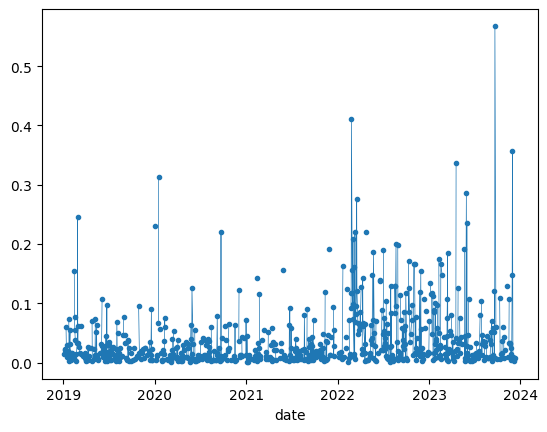

In [69]:
df.groupby('date').sum()['S_war_energy'].replace({0: np.nan}).plot(lw=.5, marker='.')

In [37]:
sorted(
    Counter([*chain(*[dict_txts[i]['narratives']['S_supply_chain']['narrative_chunk_det'] for i in dict_txts.keys()])]).items(),
    key=lambda x: x[1],
    reverse=True
    );

<AxesSubplot: >

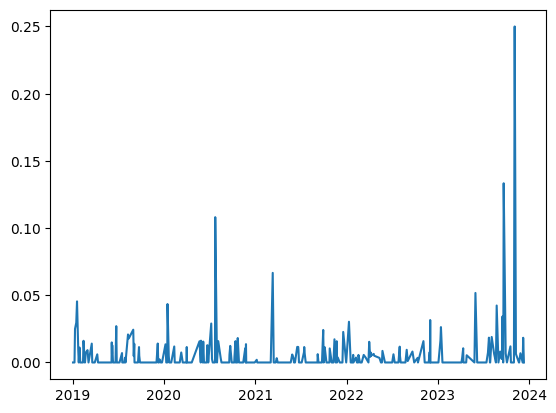

In [39]:
df['S_supply_chain'].plot()

# supervised BERT topic

In [34]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups

In [21]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.linear_model import LogisticRegression

In [35]:
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))["data"]

In [45]:
lst_topic_seeds = [
  ['term', 'condition',  'area',  'conference',  'corporation'],
  ['risk',  'outlook',  'assessment',  'credit',  'loan'],
  ['interest',  'prices',  'household',  'inflation',  'expectation']
]

In [46]:
txts = [" ".join([i.lemma_.lower() for i in doc if not (i.is_stop or i.is_punct or i.is_currency or i.is_bracket)]) for doc in lst_docs]

In [47]:
start = time.time()
topic_model = BERTopic(seed_topic_list=lst_topic_seeds, )
topics, probs = topic_model.fit_transform(txts)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
time.time() - start

In [ ]:
df = pd.DataFrame(data=[topics, probs], index=['topic', 'prob']).T
df.index.name = 'doc'

In [ ]:
df.topic.value_counts()